# Working with the St. Jude Cloud RNA-Seq counts

This Jupyter notebook is intended to serve as a proof of concept for requesting, aggregating, downloading, and then analyzing RNA-Seq expression counts from the St. Jude Cloud Genomics Platform. Counts can be downloaded without the need to submit a data access request, and generating a working `counts-matrix.tsv` and `metadata-matrix.tsv` is trivial. 

**Note.** This Jupyter notebook has not been peer reviewed and is not part of the St. Jude Cloud RNA-Seq expression landscape analysis included in the paper. Instead, it's a tutorial for downloading the counts and doing analysis yourself—the fact that we create a t-SNE plot here is a matter of coincidence. If you are interested in that reviewing the expression analysis present in the paper, please view [the paper collection in the Visualization Community](https://viz.stjude.cloud/stjudecloud/collection/stjudecloud-paper).

## Environment Setup

Below, you'll find some instructions to easily bootstrap up an environment with the necessary dependencies using [Anaconda](https://docs.anaconda.com/anaconda/install/). You'll need to be sure to run the `jupyter notebook` command _after_ you've activated this environment so the notebook runs there.

In [1]:
# conda create -c bioconda -c conda-forge -n rnaseq-count-analysis python=3.7 R matplotlib pandas rpy2 seaborn bokeh scikit-learn bioconductor-sva bioconductor-deseq2 jupyter tqdm -y
# conda activate rnaseq-count-analysis
# jupyter notebook

Next, let's load the dependencies needed to perform the analysis.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import rpy2.rinterface
import time
import tqdm
import seaborn as sns

from bokeh.plotting import figure, show 
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook
from collections import defaultdict
from sklearn.manifold import TSNE
from typing import List

sns.set(style="whitegrid")
output_notebook()

Loading BokehJS ...

We'll load the `rpy2` IPython extension so that we can easily run R commands interspersed with our Python commands and pass objects back and forth. For more information, check out [this blog post](https://www.linkedin.com/pulse/interfacing-r-from-python-3-jupyter-notebook-jared-stufft/).

In [3]:
%load_ext rpy2.ipython

Last, I've defined a number of utility functions that may or may not be used throughout the analysis. Feel free to browse through them or use them in your analysis if you find them helpful.

In [4]:
def tpm(df: pd.DataFrame, gene_length_col: str = "Gene Length", remove_gene_length_col: bool = True) -> pd.DataFrame:
    """Transforms a counts matrix containing genes (rows) and samples (cols) to
    Transcripts Per Kilobase Million. This metric is suitable for comparing across samples.
    Gene lengths should be expressed in single bases (not kilobases).
    
    Instructions credit: https://rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/
    
    Arguments:
        df(pd.DataFrame): counts matrix with genes as rows and samples as columns.
        gene_length_col(str): column containing the gene lengths (must be the same as num rows in `df`).
        remove_gene_length_col(bool): remove the gene length column once we are finished.
        
    Returns:
        (pd.DataFrame): a pandas dataframe containing the TPM transformed counts.
    """
    
    gene_lengths = df[gene_length_col]
    # 1. Divide the read counts by the length of each gene in kilobases. This gives you reads per kilobase (RPK).
    rpk = df.div(df[gene_length_col] / 1e3, axis=0)
    # 2. Count up all the RPK values in a sample and divide this number by 1,000,000. This is your “per million” scaling factor.
    sf = rpk.sum(axis=0) / 1e6
    # 3. Divide the RPK values by the “per million” scaling factor. This gives you TPM.
    result = rpk / sf
    
    if remove_gene_length_col:
        del result[gene_length_col]
        
    return result


def parse_gtf(filename: str, feature_types: List[str] = None) -> pd.DataFrame:
    """A utility method to load a GENCODE GTF into a `pandas.DataFrame`.
    
    Arguments:
        filename(str): filename to be loaded as a string.
        feature_types(List[str], optional): if provided, ignores any entry where the `feature` column is not
                                            in the provided List. Example: ['gene', 'exon'].
                                            
    Returns:
        (pd.DataFrame): the gene model as a pandas dataframe.
    """
    
    results = []
    _handle = open(filename, "r")
    group_regexes = [re.compile(pattern) for pattern in [r"(\S+) \"(\S+)\"", r"(\S+)=(\S+)"]]

    for line in tqdm.tqdm(_handle.readlines(), "Reading GTF file"):
        line = line.strip()
        
        if not line:
            break

        if line.startswith("#"):
            continue

        [seqname, source, feature, start, end, score, strand, frame, group] = line.split("\t")

        if feature_types and feature not in feature_types:
            continue

        result = {
            "seqname": seqname,
            "source": source,
            "feature": feature,
            "start": int(start),
            "end": int(end),
            "score": score,
            "strand": strand,
            "group": group
        }

        for group_attr in [s.strip() for s in group.split(";")]:
            if not group_attr:
                continue

            for regex in group_regexes:
                match = regex.match(group_attr)
                if match:
                    key, value = match.group(1, 2)
                    result["group_" + key] = value.strip()
                    break
        
        results.append(result)
    
    return pd.DataFrame(results)

## Loading the Data

You can read in the counts and metadata file and observe some general characteristics about them.

In [5]:
counts = pd.read_csv("./counts-matrix.tsv", sep="\t")
metadata = pd.read_csv("./metadata-matrix.tsv", sep="\t")

# remove non-gene entries
counts = counts[~counts['Gene Name'].str.startswith("__")]

# set indices
counts.set_index('Gene Name', inplace=True)
metadata.set_index('Sample ID', inplace=True)

# print shapes
print(f"Counts matrix shape: {counts.shape}.")
print(f"Metadata matrix shape: {metadata.shape}.")

Counts matrix shape: (59050, 1576).
Metadata matrix shape: (1576, 19).


Next, we'll prepare our `batch` column in the `metadata` array so that we can eventually join that to the `counts` column to get the known batch effects for each sample.

In [6]:
metadata['batch'] = metadata['attr_lab_strandedness'] + "_" \
                    + metadata['attr_tissue_preservative'] + "_" \
                    + metadata['attr_library_selection_protocol'] + "_" \
                    + metadata['attr_read_type']

## Prepare the Gene Model

Next, we'll need to download the exact gene model used in the [RNA-Seq v2 harmonization pipeline](https://stjudecloud.github.io/rfcs/0001-rnaseq-workflow-v2.0.0.html#reference-files). First, we'll download the gene model from the GENCODE website.

In [7]:
%%bash

[[ -z $NOTEBOOK_TMP_DIR ]] && NOTEBOOK_TMP_DIR=`mktemp -d` || echo "Reusing temporary directory from last time...";
echo "Temporary directory: $NOTEBOOK_TMP_DIR"
cd $NOTEBOOK_TMP_DIR

[[ -f "gencode.v31.annotation.gtf.gz" ]] && rm gencode.v31.annotation.gtf.gz 
[[ -f "gencode.v31.annotation.gtf" ]] && rm gencode.v31.annotation.gtf

wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_31/gencode.v31.annotation.gtf.gz 2>/dev/null
echo "0aac86e8a6c9e5fa5afe2a286325da81  gencode.v31.annotation.gtf.gz" > gencode.v31.annotation.gtf.gz.md5 
md5sum -c gencode.v31.annotation.gtf.gz.md5
# > gencode.v31.annotation.gtf.gz: OK

gunzip gencode.v31.annotation.gtf.gz
echo "4e22351ae216e72aa57cd6d6011960f8  gencode.v31.annotation.gtf" > gencode.v31.annotation.gtf.md5
md5sum -c gencode.v31.annotation.gtf.md5
# > gencode.v31.annotation.gtf: OK

Temporary directory: /var/folders/z9/7n3_5hks21s7d1bz5ppx2zqxx4ymd8/T/tmp.fA4ZJ8E0
gencode.v31.annotation.gtf.gz: OK
gencode.v31.annotation.gtf: OK


Next, we'll load the gene model into `gene_model`.

In [8]:
gene_model = parse_gtf("gencode.v31.annotation.gtf", feature_types=['gene', 'exon'])

Reading GTF file: 100%|██████████| 2881891/2881891 [00:29<00:00, 98817.87it/s] 


## Calculate Gene Lengths (Optional) 

If you're interested in using TPMs, the gene lengths will be needed as aggregated by the `gene_name` group attribute in the GTF (St. Jude Cloud counts by `gene_name`, not by transcript!). Below is an optional code block to run that computes the `gene_length` for each gene in the gene model. The algorithm is a simple implementation:

- Examine every entry with `feature == "gene"` and create an array of 0's corresponding to the `gene_name` that is equal to the length (end-start) of that entry.
- Examine all of the exons, and for each one, fill in the appropriate offset coordinates with 1's for the array corresponding to the `gene_name` for that entry.
- Sum up all of the 1's for each array to get the gene length.

In [9]:
%%time

print("  [*] Computing gene lengths...")
only_genes = gene_model[gene_model['feature'] == 'gene']
only_exons = gene_model[gene_model['feature'] == 'exon']
gene_start_offset = {}
gene_end_offset = {}
gene_exon_intersection = {}
gene_total_exon_size = {}
gene_length = {}

for (index, value) in tqdm.tqdm(only_genes.iterrows(), "Aggregating gene start and end positions", only_genes.shape[0]):
    gene_name = value['group_gene_name']
    start = value['start']
    end = value['end']
    size = end - start
    
    if size <= 0:
        raise RuntimeError("Size of gene is negative!")
        
    gene_start_offset[gene_name] = start
    gene_end_offset[gene_name] = end
    gene_exon_intersection[gene_name] = np.zeros(size)
    gene_total_exon_size[gene_name] = 0
    gene_length[gene_name] = end - start
    
for (index, value) in tqdm.tqdm(only_exons.iterrows(), "Overlaying exonic regions", total=only_exons.shape[0]):
    gene_name = value['group_gene_name']
    offset = gene_start_offset[gene_name]
    start = value['start'] - offset
    end = value['end'] - offset
    exon_length = end - start
    gene_exon_intersection[gene_name][start:end] = 1
    gene_total_exon_size[gene_name] += exon_length

print("  [*] Producing summary dataframe...")
time.sleep(0.5) # output sometimes gets messed up here.
results = []
for (gene, exonic_intersection) in tqdm.tqdm(gene_exon_intersection.items(), "Calculating gene lengths", total=len(gene_exon_intersection)):
    result = {"Gene Name": gene, "Gene Length": np.sum(exonic_intersection).astype(int)}
    result['Pct_filled'] = result['Gene Length'] / gene_length[result['Gene Name']] * 100
    result['Exonic_redundancy'] = (gene_total_exon_size[result['Gene Name']] / result['Gene Length']) * 100
    results.append(result)
    
gene_lengths = pd.DataFrame(results)
gene_lengths.set_index('Gene Name', inplace=True)
print(f"Gene lengths shape: {gene_lengths.shape}")

  [*] Computing gene lengths...


Overlaying exonic regions: 100%|██████████| 1363843/1363843 [01:39<00:00, 13711.50it/s]


  [*] Producing summary dataframe...


Calculating gene lengths: 100%|██████████| 59050/59050 [00:12<00:00, 4698.01it/s]


Gene lengths shape: (59050, 3)
CPU times: user 1min 49s, sys: 8.11 s, total: 1min 57s
Wall time: 1min 58s


Just for curiosity's sake (and as a sanity check), let's see the breakdown of (i) how much of each gene is taken up by an exonic region and (ii) some idea of the duplication rate amongst exons described in the gene model.

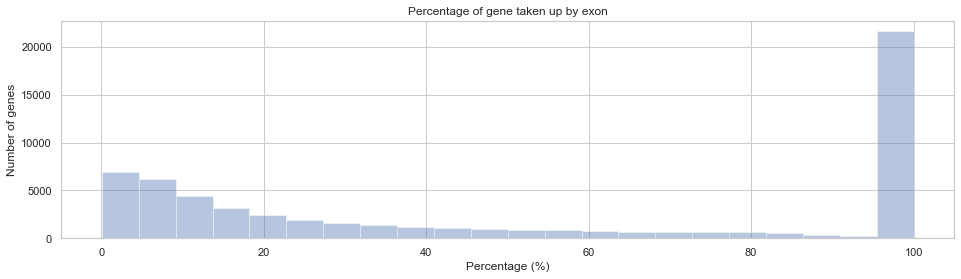

In [10]:
plt.figure(figsize=(16,4))
sns.distplot(gene_lengths['Pct_filled'], kde=False)
plt.title("Percentage of gene taken up by exon")
plt.xlabel('Percentage (%)')
plt.ylabel('Number of genes')
plt.show()

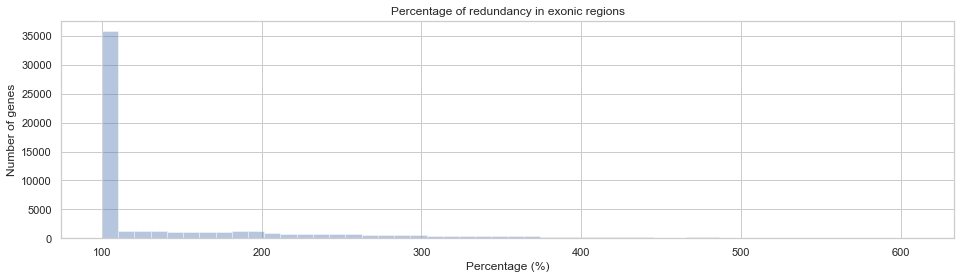

In [11]:
plt.figure(figsize=(16,4))

# filter the tail ends as it makes the graph very hard to read with the outliers.
# you may disable this if you wish to see the true distribution.
lower_bound = gene_lengths['Exonic_redundancy'] >= gene_lengths['Exonic_redundancy'].quantile(0.01)
upper_bound = gene_lengths['Exonic_redundancy'] <= gene_lengths['Exonic_redundancy'].quantile(0.99)

sns.distplot(gene_lengths[lower_bound & upper_bound].sort_values(by='Exonic_redundancy', ascending=False)['Exonic_redundancy'], kde=False)
plt.title("Percentage of redundancy in exonic regions")
plt.xlabel('Percentage (%)')
plt.ylabel('Number of genes')
plt.show()

## Filter Counts

Now that we have loaded all of the data, we can start performing all of our analysis on the counts data. Before we start transforming the data, there are several filters we're going to want to apply to achieve good results, including:

1. Removing any genes which exhibit low expression (as defined by all samples have <10 reads for the gene).
2. Filtering non protein-coding genes from the gene model.
3. Removing genes which are blacklisted (as defined by the blacklist we used for the St. Jude Cloud expression landscape analysis in the paper).

Below, we enact these filters.

In [14]:
shape_before = counts.shape
counts = counts[~counts.apply(lambda row: np.all(np.abs(row) < 10), axis=1)]
shape_after = counts.shape
print(f"[Low Expression Filter] Counts matrix shape changed from {shape_before} to {shape_after} ({shape_before[0] - shape_after[0]} genes removed).")

[Low Expression Filter] Counts matrix shape changed from (56021, 1576) to (56021, 1576) (0 samples removed).


In [17]:
protein_coding_genes = gene_model[(gene_model['feature'] == "gene") & (gene_model['group_gene_type'] == "protein_coding")]["group_gene_name"].unique()
print(f"[Protein Coding Gene Filter] Found {protein_coding_genes.size} protein coding genes in gene model.")

shape_before = counts.shape
counts = counts[counts.index.isin(protein_coding_genes)]
shape_after = counts.shape
print(f"[Protein Coding Gene Filter] Counts matrix shape changed from {shape_before} to {shape_after} ({shape_before[0] - shape_after[0]} genes removed).")

[Protein Coding Gene Filter] Found 19942 protein coding genes in gene model.
[Protein Coding Gene Filter] Counts matrix shape changed from (19448, 1576) to (19448, 1576) (0 genes removed).


In [18]:
# blacklist is from the St. Jude Cloud expression landscape analysis included in the St. Jude Cloud paper.
blacklist_regex = '|'.join(["ENSG00000174358", "ENSG00000162722", "ENSG00000238243", "ENSG00000165949", "ENSG00000180537", "ENSG00000076864", "ENSG00000141469", "ENSG00000162366", "ENSG00000047597", "ENSG00000137198",
"ENSG00000158856", "ENSG00000184792", "ENSG00000145335", "ENSG00000213934", "ENSG00000196565", "ENSG00000188536", "ENSG00000244734", "ENSG00000206172", "ENSG00000133069", "ENSG00000143416",
"ENSG00000206177", "ENSG00000004939", "ENSG00000158578", "ENSG00000223609", "ENSG00000204010", "ENSG00000167768", "ENSG00000198046", "ENSG00000136929", "ENSG00000152078", "ENSG00000204613",
"ENSG00000112077", "ENSG00000198336", "ENSG00000170180", "ENSG00000169877", "ENSG00000133742", "ENSG00000105610", "ENSG00000250361", "ENSG00000240583", "ENSG00000137460", "ENSG00000087085",
"ENSG00000196188", "ENSG00000188582", "ENSG00000213088", "ENSG00000135047", "ENSG00000165702", "ENSG00000198959", "ENSG00000116675", "ENSG00000055118", "ENSG00000070182", "ENSG00000188672",
"ENSG00000133488", "ENSG00000197993", "ENSG00000104267", "ENSG00000135218", "ENSG00000189056", "ENSG00000090013", "ENSG00000178752", "ENSG00000169429", "ENSG00000110203", "ENSG00000242550",
"ENSG00000121552", "ENSG00000158825", "ENSG00000163221", "ENSG00000143546", "ENSG00000163220", "ENSG00000115828", "ENSG00000121316", "ENSG00000111052", "ENSG00000162747", "ENSG00000163563",
"ENSG00000171051", "ENSG00000171049", "ENSG00000163421", "ENSG00000103569", "ENSG00000186431", "ENSG00000126262", "ENSG00000159339", "ENSG00000189068", "ENSG00000169385", "ENSG00000169397",
"ENSG00000149516", "ENSG00000105205", "ENSG00000100448", "ENSG00000196415", "ENSG00000197561", "ENSG00000164099", "ENSG00000182217", "ENSG00000183941", "ENSG00000203852", "ENSG00000203811",
"ENSG00000124610", "ENSG00000158406", "ENSG00000197837", "ENSG00000184348", "ENSG00000196331", "ENSG00000233822", "ENSG00000198366", "ENSG00000180596", "ENSG00000158373", "ENSG00000197914",
"ENSG00000197153", "ENSG00000124635", "ENSG00000196787", "ENSG00000196747", "ENSG00000203813", "ENSG00000256316", "ENSG00000256018", "ENSG00000196374", "ENSG00000196176", "ENSG00000168242",
"ENSG00000182572", "ENSG00000184357", "ENSG00000184825", "ENSG00000184270", "ENSG00000184260", "ENSG00000197238", "ENSG00000137259", "ENSG00000182611", "ENSG00000196532", "ENSG00000196226",
"ENSG00000185130", "ENSG00000198374", "ENSG00000188987", "ENSG00000197697", "ENSG00000198327", "ENSG00000198558", "ENSG00000197061", "ENSG00000124529", "ENSG00000203814", "ENSG00000183598",
"ENSG00000168298", "ENSG00000124575", "ENSG00000197846", "ENSG00000187990", "ENSG00000168274", "ENSG00000197459", "ENSG00000198518", "ENSG00000197409", "ENSG00000187837", "ENSG00000203812",
"ENSG00000183558", "ENSG00000179869", "ENSG00000102837", "ENSG00000239839", "ENSG00000164821", "ENSG00000164047", "ENSG00000096006", "ENSG00000157551", "ENSG00000127954", "ENSG00000166527",
"ENSG00000257335", "ENSG00000122641", "ENSG00000173391", "ENSG00000186529", "ENSG00000138772", "ENSG00000133048", "ENSG00000101425", "ENSG00000124469", "ENSG00000148346", "ENSG00000118113",
"ENSG00000012223", "ENSG00000257017", "ENSG00000134827", "ENSG00000204936", "ENSG00000100985", "ENSG00000172232", "ENSG00000073756", "ENSG00000123689", "ENSG00000142676", "ENSG00000142937",
"ENSG00000177954", "ENSG00000171863", "ENSG00000071082", "ENSG00000197756", "ENSG00000144713", "ENSG00000174748", "ENSG00000188846", "ENSG00000162244", "ENSG00000114391", "ENSG00000163584",
"ENSG00000163923", "ENSG00000182899", "ENSG00000163682", "ENSG00000109475", "ENSG00000145425", "ENSG00000145592", "ENSG00000186468", "ENSG00000164587", "ENSG00000037241", "ENSG00000231500",
"ENSG00000124614", "ENSG00000198755", "ENSG00000146223", "ENSG00000112306", "ENSG00000198034", "ENSG00000241343", "ENSG00000198918", "ENSG00000008988", "ENSG00000147604", "ENSG00000156482",
"ENSG00000161016", "ENSG00000137154", "ENSG00000136942", "ENSG00000197958", "ENSG00000148303", "ENSG00000138326", "ENSG00000177600", "ENSG00000166441", "ENSG00000110700", "ENSG00000149273",
"ENSG00000118181", "ENSG00000197728", "ENSG00000229117", "ENSG00000089009", "ENSG00000089157", "ENSG00000122026", "ENSG00000165496", "ENSG00000213741", "ENSG00000165502", "ENSG00000185088",
"ENSG00000174444", "ENSG00000137818", "ENSG00000184779", "ENSG00000182774", "ENSG00000140986", "ENSG00000140988", "ENSG00000134419", "ENSG00000167526", "ENSG00000161970", "ENSG00000198242",
"ENSG00000125691", "ENSG00000108298", "ENSG00000131469", "ENSG00000172809", "ENSG00000265681", "ENSG00000171858", "ENSG00000115268", "ENSG00000130255", "ENSG00000233927", "ENSG00000105640",
"ENSG00000105193", "ENSG00000105372", "ENSG00000063177", "ENSG00000142541", "ENSG00000142534", "ENSG00000170889", "ENSG00000108107", "ENSG00000083845", "ENSG00000100316", "ENSG00000229988",
"ENSG00000213931", "ENSG00000130656", "ENSG00000206178", "ENSG00000086506"])
blacklist_genes = gene_model[(gene_model['feature'] == "gene") & (gene_model['group_gene_id'].str.contains(blacklist_regex))]["group_gene_name"].unique()
print(f"[Gene Blacklist Filter] Removing {blacklist_genes.size} blacklist genes.")

shape_before = counts.shape
counts = counts[~counts.index.isin(blacklist_genes)]
shape_after = counts.shape
print(f"[Gene Blacklist Filter] Counts matrix shape changed from {shape_before} to {shape_after} ({shape_before[0] - shape_after[0]} genes removed).")

[Gene Blacklist Filter] Removing 223 blacklist genes.
[Gene Blacklist Filter] Counts matrix shape changed from (19448, 1576) to (19228, 1576) (220 genes removed).


From this point on, we've no need to do any data munging with the `pandas.DataFrame` objects. Thus, to make things run smoothly, we are going to go ahead and extract the counts data and relevant metadata to a number of `numpy` arrays. This is what is expected by `DESeq2`/`sva` (which both expect R `matrix` objects, which `numpy` arrays automatically map to) and `scikit-learn`. Note that `pandas.DataFrame` objects map to `data.frame` objects in R, which is not desirable.

We'll set the following:

- `batch`: A 1-D of known batch effects for the ordered sample names with shape (samples, ).
- `X`: A 2-D matrix of RNA-Seq expression counts where genes are in rows and samples are in columns with shape (genes, samples).
- `samples`: A 1-D matrix containing the ordered sample names aligned with the columns in `X` with shape (samples, ).
- `genes`: A 1-D matrix containing the ordered gene names with shape (genes, ).

**Caution**, from this point on, you'll need to be ultra careful to keep these numerical matrices in the same order and not mix up columns and/or rows. Pandas will not keep these straight, and you cannot easily join the data on an index anymore.

In [19]:
counts = pd.merge(counts.T, metadata[['batch']], how="left", left_index=True, right_index=True)
batch = counts['batch']
del counts['batch']
counts = counts.T
X = counts.values
samples = counts.columns.values
genes = counts.index.values

print(f"batch shape: {batch.shape}.")
print(f"X shape: {X.shape}.")
print(f"samples shape: {samples.shape}.")
print(f"genes shape: {genes.shape}.")

batch shape: (1576,).
X shape: (19228, 1576).
samples shape: (1576,).
genes shape: (19228,).


Just to avoid any confusion in the future, we will delete the `counts` and `metadata` objects here so that the `pandas.DataFrame`s aren't used.

In [21]:
del metadata
del counts

NameError: name 'metadata' is not defined

## Matrix Transformations

Now we can begin applying the necessary transformations appropriate for data visualization using t-SNE. This is where it becomes very useful to switch back and forth between Python and R seamlessly using `rpy2`. 

First, we'll use `DESeq2`'s `varianceStabilizingTransformation()` function ([docs](https://rdrr.io/bioc/DESeq2/man/varianceStabilizingTransformation.html)) to transform the counts matrix to be homoskedastic in nature. Their documentation does a great job in explaining why this is desirable, so we leave that to their documentation page.

In [24]:
%%R -i X -o X
library(DESeq2)
X <- varianceStabilizingTransformation(X)

R[write to console]: Error: package or namespace load failed for ‘DESeq2’ in dyn.load(file, DLLpath = DLLpath, ...):
 unable to load shared object '/Users/cmcleod/conda/envs/rnaseq-count-analysis/lib/R/library/stringi/libs/stringi.dylib':
  dlopen(/Users/cmcleod/conda/envs/rnaseq-count-analysis/lib/R/library/stringi/libs/stringi.dylib, 6): Library not loaded: @rpath/libicui18n.58.dylib
  Referenced from: /Users/cmcleod/conda/envs/rnaseq-count-analysis/lib/R/library/stringi/libs/stringi.dylib
  Reason: image not found




Error: package or namespace load failed for ‘DESeq2’ in dyn.load(file, DLLpath = DLLpath, ...):
 unable to load shared object '/Users/cmcleod/conda/envs/rnaseq-count-analysis/lib/R/library/stringi/libs/stringi.dylib':
  dlopen(/Users/cmcleod/conda/envs/rnaseq-count-analysis/lib/R/library/stringi/libs/stringi.dylib, 6): Library not loaded: @rpath/libicui18n.58.dylib
  Referenced from: /Users/cmcleod/conda/envs/rnaseq-count-analysis/lib/R/library/stringi/libs/stringi.dylib
  Reason: image not found


In [ ]:
tpm_df = tpm(merged)
metadata['covariates'] = metadata['attr_lab_strandedness'] + "_" \
                       + metadata['attr_tissue_preservative'] + "_" \
                       + metadata['attr_library_selection_protocol'] + "_" \
                       + metadata['attr_read_type']
tpm_df = pd.merge(tpm_df.T, metadata[['covariates']], how="left", left_index=True, right_index=True)
# print(tpm_df.head())
covariates = tpm_df['covariates'].T.astype('category').cat.codes.values
del tpm_df['covariates']
tpm_df = tpm_df.T
print(tpm_df.head())
genes = tpm_df.index.values
samples = tpm_df.columns.values
tpm_df = tpm_df.values
print(genes)
print(samples)

In [ ]:
%%R -i tpm_df -i covariates -o tpm_df_normalized

library(sva)
print(dim(tpm_df))
# tpm_df <- as.matrix(tpm_df)
tpm_df_normalized <- ComBat(tpm_df, covariates, mean.only = FALSE)

In [ ]:
new_df = pd.DataFrame(tpm_df_normalized)
new_df.columns = samples
new_df.index = genes
print(new_df.head())

In [ ]:
# most differentially expressed genes
top_de_genes = new_df.mad(axis=1).sort_values(ascending=False).head(1000).index.values
top_tpm = new_df[new_df.index.isin(top_de_genes)]

samples = top_tpm.columns.values
X = top_tpm.values.T

print(samples.shape)
print(X.shape)

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=5000, angle=0)
tsne_results = tsne.fit_transform(X)
print(tsne_results.shape)

In [ ]:
tsne_df = pd.DataFrame(tsne_results, columns=["X", "Y"])
tsne_df['Sample ID'] = samples
tsne_df.set_index('Sample ID', inplace=True)
final_df = pd.merge(metadata, tsne_df, how="right", left_index=True, right_index=True)
final_df['sj_diseases'] = final_df['sj_diseases'].astype('category')
final_df['sj_long_disease_name'] = final_df['sj_long_disease_name'].astype('category')
final_df['attr_diagnosis'] = final_df['attr_diagnosis'].astype('category')

DEFAULT_COLOR="black" # for anything not defined in this map
palette = {
    "ACC": "#66C2A6", "ACPG": "red", "AFH": "#d3d3d3", "ALAL": "black", "ALCL": "#f9779d", "AMKL": "#008cff",
    "AML": "#00c0ff", "AML": "#00c0ff", "APLPMLRARA": "#ffa500", "ARMS": "#00aeff", "ASPS": "#d3d3d3", "ATRT": "#f9779d",
    "AULKMT2A": "#d3d3d3", "BALLBCRABL1": "#ff00ff", "BALLBCRABL1L": "#9759d5", "BALLDUX4IGH": "#696969", "BALLDUX4IGHL": "#d3d3d3", "BALLETV6RUNX1": "#ffd700",
    "BALLETV6RUNX1L": "#d3d3d3", "BALLHLF": "#d3d3d3", "BALLHYPER": "#3E9F32", "BALLHYPO": "#483d8b", "BALLIAMP21": "#0000ff", "BALLIGHCEBPD": "#d3d3d3",
    "BALLKMT2A": "#7cfc00", "BALLMEF2D": "#66C2A6", "BALLMYC": "#d3d3d3", "BALLNOS": "#d3d3d3", "BALLNUTM1": "#8b0000", "BALLPAX5": "#e88c38",
    "BALLPAX5P80R": "#ffa500", "BALLTCF3PBX1": "#c8a2c8", "BALLZNF384": "#A8DD00", "BALLZNF384L": "#d3d3d3", "BCUP": "#d3d3d3", "BERMS": "#9ce5f0",
    "BGCT": "yellow", "BL": "#d3d3d3", "BMGCT": "yellow", "BYST": "yellow", "CBF": "#00c0ff", "CCA": "yellow",
    "CCRCC": "#d3d3d3", "CCSK": "#d3d3d3", "CHDM": "#d3d3d3", "CHOS": "#ff00ff", "CML": "#d3d3d3", "CPC": "#ffd700",
    "DES": "#8b0000", "DFSP": "#d3d3d3", "DLBCLNOS": "#d3d3d3", "DSRCT": "#daa520", "DYS": "yellow", "EBMT": "#ff7b29",
    "ECNOS": "yellow", "EPMT": "#ffccff", "EPMTPF": "#ff00ff", "EPMTST": "#ffccff", "EPMTSU": "#c042ff", "ERMS": "#0000ff",
    "ETMR": "#ff7b29", "EWS": "#d277f3", "FIBS": "#d3d3d3", "FMS": "#d3d3d3", "GCT": "yellow", "GIST": "#d3d3d3",
    "GMN": "yellow", "GNG": "#d3d3d3", "HB": "#e76836", "HCC": "#ffa500", "HGGNOS": "#0006c2", "HGNET": "#8fb90a",
    "IFS": "#d3d3d3", "LGGNOS": "#00c0ff", "MBL": "#7cfc00", "MBLG3": "#2fd090", "MBLG4": "#2fd090", "MBLSHH": "#29a20b",
    "MBLWNT": "#287415", "MBT": "#d3d3d3", "MDS": "#d3d3d3", "MEL": "#9531ed", "MEPMST": "#ffccff", "MFH": "#d3d3d3",
    "MGCT": "yellow", "MGCTNOS": "yellow", "MNG": "#8b0000", "MPE": "#ffccff", "MPEFV": "#ffccff", "MPEPF": "#ff00ff",
    "MPNST": "#d3d3d3", "MRT": "#c01111", "MRTL": "#c01111", "MS": "#d3d3d3", "MSCERMS": "#00c0ff", "MUCC": "#d3d3d3",
    "NBL": "#f9779d", "NFIB": "#d3d3d3", "ODYS": "yellow", "OMGCT": "yellow", "OS": "#ff00ff", "PANET": "#d3d3d3",
    "PBL": "#d3d3d3", "PDYS": "yellow", "PRCC": "#eb1414", "RBL": "#ffd700", "RCC": "#eb1414", "RCSNOS": "#d3d3d3",
    "RMS": "#00c0ff", "SCCNOS": "#d3d3d3", "SCRMS": "#d3d3d3", "SCSNOS": "#d3d3d3", "SCSRMS": "#d3d3d3", "SCUP": "#d3d3d3",
    "SETTLE": "#d3d3d3", "SIPT": "#d3d3d3", "SYNS": "#d3d3d3", "TALL": "red", "TALLKMT2A": "red", "THFO": "#11c598",
    "THPA": "#11c598", "TLL": "#d3d3d3", "TTC": "yellow", "TTNOS": "yellow", "UESL": "#ffa500", "WT": "#29a20b",
    "WTB": "#7cfc00", "YSTNOS": "yellow"
}

final_df['color'] = final_df['sj_diseases'].apply(lambda x: palette.get(x, DEFAULT_COLOR))
final_df.index.set_names('sample_id', inplace=True)
final_df.reset_index(inplace=True)

In [ ]:
p = figure(plot_width=900, plot_height=600, tooltips=[("Sample ID", "@sample_id"), ("Diagnosis Code", "@sj_diseases"), ("Diagnosis", "@sj_long_disease_name")])
p.scatter(x="X", y="Y", color="color", source=ColumnDataSource(final_df))
show(p)

# fig, ax = plt.subplots()

# grouped = final_df.groupby('sj_diseases')
# for (key, group), color in zip(grouped, palette):
#     group.plot(ax=ax, kind='scatter', x='X', y='Y', label=key, color=palette.get(key, "black"))

# plt.show()

## Untriaged

In [ ]:
expected_shape = (counts.shape[0], counts.shape[1] + 1)
merged = pd.merge(df[['Gene Length']], counts, how="right", left_index=True, right_index=True)
merged['Gene Length'] = merged['Gene Length'].astype(np.int64)
assert merged.shape == expected_shape, "Merged shape does not match expected shape. Error!"